# <div style="color:rgb(200,180,180);font-size:42px;"><u>***UCI Breast Cancer Pipeline Project***</u></div>
## **Some additional variable information from UCI:**

1 )  ID number <br>
2 )  Diagnosis (M = malignant, B = benign) <br>

3-32 ) Below &#8595;

### **Ten real-valued features are computed for each cell nucleus:**

1) radius (mean of distances from center to points on the perimeter)
2) texture (standard deviation of gray-scale values)
3) perimeter
4) area
5) smoothness (local variation in radius lengths)
6) compactness (perimeter^2 / area - 1.0)
7) concavity (severity of concave portions on the contour)
8) concave points (number of concave portions of the contour)
9) symmetry
10) fractal dimension ("coastline approximation" - 1)
###


## 0. Import Modules:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## 1. Import UCI Dataset &#8594; Write Dataset to Local CSV

In [3]:
## Import UCI Dataset and write to local csv
## NOTE: Commented out code for the sake of minimizing runtime, it is functional/reusable.
"""
from ucimlrepo import fetch_ucirepo
breast_ca = fetch_ucirepo(id=17)

breast_ca_df = breast_ca.data.original
breast_ca_df.to_csv('UCI_BreastCancer.csv', index=False)
print('Successfully wrote dataset to csv file!')
"""

# Read csv and store as df
df = pd.read_csv('UCI_BreastCancer.csv')

## 2. Search for missing values and verify shape &#8594; Identify Feature Types

In [4]:
# Search Dataset for missing / null values:
print('\n')
try:
    if df.isnull().sum().any()>0:
        print('NaN values found: ', df.isnull().sum())
    else:
        print('No NaN or null values found')
except Exception as e:
    print(e)

# Consider the number of unique values for each feature:
# All features are numeric.
# print(df.nunique())

# Verify features and shape:
print('\nDATASET COLUMNS: \n',df.columns)
print('\nDATASET SHAPE:  ',df.shape)



No NaN or null values found

DATASET COLUMNS: 
 Index(['ID', 'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3', 'Diagnosis'],
      dtype='object')

DATASET SHAPE:   (569, 32)


## 3. Define Target (y) and Features (X) &#8594; Convert Target to Binary &#8594; Train_Test_Split()

In [5]:
# Define features and target
y = df.Diagnosis
X = df.drop(columns=['Diagnosis','ID'])

print('\n')
# Verify expected shapes before and after:
print('X shape: ',X.shape)
print('y shape: ',y.shape)

# Convert target data to binary and verify value_counts.
print('\nTarget values: Benign (B) and Malignant (M)')
print('Target prior to binary conversion: \n',y.value_counts())
try:
    y = pd.DataFrame(np.where(y == 'M',1,0), columns=['Diagnosis'])
    y = y.Diagnosis
    print('\nTarget post binary conversion: \n',y.value_counts(),'\n')

except Exception as e:
    print(e)

# Verify expected shapes before and after:
print('X shape: ',X.shape)
print('y shape: ',y.shape)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)



X shape:  (569, 30)
y shape:  (569,)

Target values: Benign (B) and Malignant (M)
Target prior to binary conversion: 
 Diagnosis
B    357
M    212
Name: count, dtype: int64

Target post binary conversion: 
 Diagnosis
0    357
1    212
Name: count, dtype: int64 

X shape:  (569, 30)
y shape:  (569,)


## 4. Lasso and LDA &#8594; Exploratory Data Analysis and Feature Selection

In [6]:
# Summary of findings:
# Lasso L1 Regularization outperforms Linear Discriminant Analysis (LDA) for feature selection performance.
print('\nLasso L1 Regularization outperforms Linear Discriminant Analysis (LDA) for feature selection performance.')

from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# LASSO feature set:
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_L_train = X_train_scale[X_train_scale.columns[np.abs(reg.coef_) > 0.001]]
X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_L_test = X_test_scale[X_test_scale.columns[np.abs(reg.coef_) > 0.001]]
print('X_L_train shape: \t',X_L_train.shape)

# LDA feature set:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)
X_LDA_train = X_train_scale[X_train_scale.columns[np.abs(clf.coef_[0]) > 0.7]]
X_LDA_test = X_test_scale[X_test_scale.columns[np.abs(clf.coef_[0]) > 0.7]]
print('X_LDA_train shape:\t',X_LDA_train.shape)

# Comparing selected features:
s_lasso = pd.Series(X_L_train.columns,name='Lasso Features').sort_values()
s_lda = pd.Series(X_LDA_train.columns,name='LDA Features').sort_values()
s_lasso = pd.Series(s_lasso.values,name='Lasso Features')
s_lda = pd.Series(s_lda.values,name='LDA Features')
featureset_compare = pd.concat([s_lasso,s_lda],axis=1)
print(f'\n{featureset_compare}')


# For loop to compare Lasso and LDA findings:
score_list = list()
for i in range(1,51):
    # Lasso features on SGDClassifier:
    clf_validate1 = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='hinge')
    clf_validate1.fit(X_L_train,y_train)
    lasso_score = clf_validate1.score(X_L_test,y_test)
    # LDA features on SGDClassifier:
    clf_validate1.fit(X_LDA_train,y_train)
    lda_score = clf_validate1.score(X_LDA_test,y_test)
    # Append:
    score_list.append([i+1,lasso_score,lda_score])

# Comparing results from loop:
print('\nAvg results from fitting SGDC with Lasso and LDA feature sets (50 times): ',)
c_names = ['random_state','lasso_score','lda_score']
scores_df = pd.DataFrame(score_list,columns=c_names)
print(f'Lasso Avg Score: \t{scores_df["lasso_score"].mean():.4f}')
print(f'LDA Avg Score: \t\t{scores_df["lda_score"].mean():.4f}')
print(f'Lasso Std Dev: \t\t{scores_df["lasso_score"].std():.4f}')
print(f'LDA Std Dev: \t\t{scores_df["lda_score"].std():.4f}')



Lasso L1 Regularization outperforms Linear Discriminant Analysis (LDA) for feature selection performance.
X_L_train shape: 	 (455, 19)
X_LDA_train shape:	 (455, 19)

        Lasso Features        LDA Features
0                area2               area1
1         compactness1               area2
2         compactness2               area3
3      concave_points1        compactness1
4      concave_points2     concave_points1
5      concave_points3     concave_points2
6           concavity2     concave_points3
7           concavity3          concavity1
8   fractal_dimension1          concavity2
9   fractal_dimension3          concavity3
10             radius2  fractal_dimension1
11             radius3  fractal_dimension3
12         smoothness2          perimeter1
13         smoothness3          perimeter3
14           symmetry2             radius1
15           symmetry3             radius2
16            texture1             radius3
17            texture2         smoothness2
18            te

## 4.1. Lasso L1 Regularization



Lasso(alpha=0.0005) score:	 0.725 	Number of features with a non-zero coef:  26
Lasso(alpha=0.002) score:	 0.730 	Number of features with a non-zero coef:  24
Lasso(alpha=0.005) score:	 0.718 	Number of features with a non-zero coef:  19
Lasso(alpha=0.05) score:	 0.666 	Number of features with a non-zero coef:  5

Best score: 
0.730


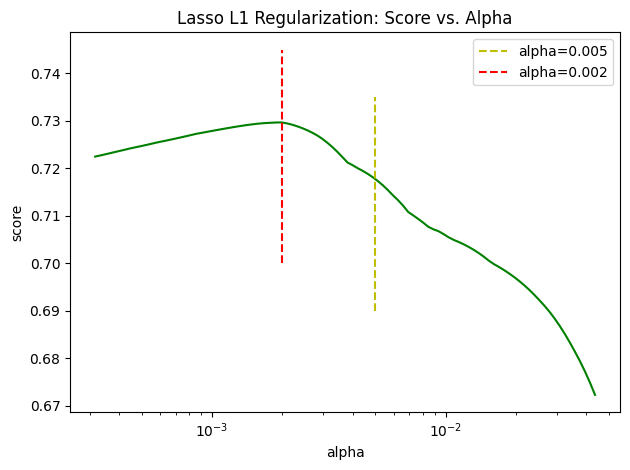

<Figure size 640x480 with 0 Axes>

In [7]:
# Initialize scaler and fit_transform:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

print('\n')
# Loop to show scores and number of features with non-zero coefficients:
show_list = [0.0005,0.002,0.005,0.05]
for i in show_list:
    reg = Lasso(alpha=i)
    reg.fit(X_train_scale,y_train)
    coefs = pd.Series(reg.coef_,X.columns)
    print(f'Lasso(alpha={i}) score:\t',f'{reg.score(X_test_scale, y_test):.3f}',
          '\tNumber of features with a non-zero coef: ', coefs[reg.coef_ != 0].shape[0])

# Loop to analyze for any meaningful impact of alpha on the score:
score_list = list()
try:
    for i in np.logspace(-3.5,-1.36,100):
        reg = Lasso(alpha=i)
        reg.fit(X_train_scale,y_train)
        coefs = pd.Series(reg.coef_,X.columns)
        score_list.append([i,reg.score(X_test_scale, y_test)])
except Exception as e:
    print(e)

c_names = ['alpha:','score:']
score_df = pd.DataFrame(score_list,columns=c_names)
max_score = score_df['score:'].max()
print(f'\nBest score: \n{max_score:.3f}')

plt.plot(score_df['alpha:'],score_df['score:'],color='green',scalex=True)
plt.plot([0.005,0.005],[0.69,0.735],color='y',linestyle='--',label='alpha=0.005')
plt.plot([0.002,0.002],[0.70,0.745],color='red',linestyle='--',label='alpha=0.002')
plt.legend()
plt.xlabel('alpha')
plt.xscale('log')
plt.ylabel('score')
plt.title('Lasso L1 Regularization: Score vs. Alpha')
plt.tight_layout()
plt.show()
plt.clf()

## 4.1.1. Lasso L1 Regularization - Coefficients

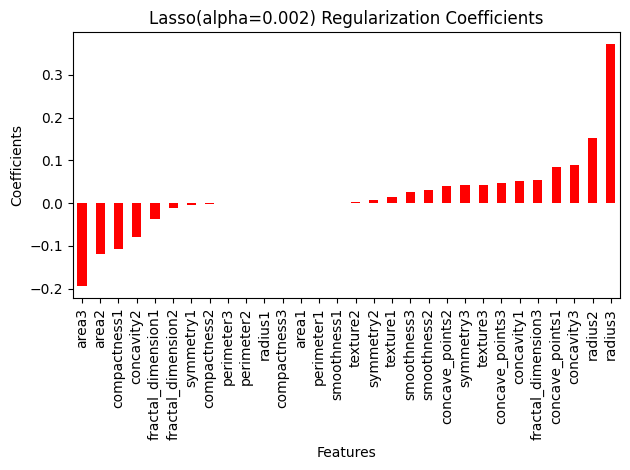

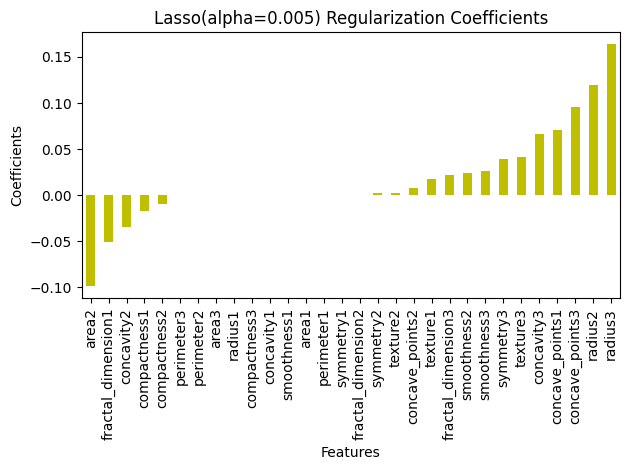

<Figure size 640x480 with 0 Axes>

In [8]:
# Supporting visuals for Lasso L1 Regularization tuning of alpha:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
print('\n')
# Plot of alpha=0.002 (RED)
reg = Lasso(alpha=0.002)
reg.fit(X_train_scale,y_train)
coefs = pd.Series(reg.coef_,X.columns).sort_values()
coefs.plot(kind='bar',color='red')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso(alpha=0.002) Regularization Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.clf()

print('\n')
# Plot of alpha=0.005 (YELLOW)
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)
coefs = pd.Series(reg.coef_,X.columns).sort_values()
coefs.plot(kind='bar',color='y')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso(alpha=0.005) Regularization Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.clf()


## 4.1.2. Lasso L1 Regularization - Feature Selection
*<div style="font-size:16px;color:lightpink"> *Note: Defining new Lasso features training / testing sets as* **X_L_train** *and* **X_L_test** </div>*

In [9]:
# Using alpha=0.005 (19 features with non-zero coefficients)

# Ensure a known starting condition before fitting Lasso:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit Lasso with alpha=0.005:
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)

# Select features with coefficients > 0.001:
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_L_train = X_train_scale[X_train_scale.columns[np.abs(reg.coef_) > 0.001]]

X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_L_test = X_test_scale[X_test_scale.columns[np.abs(reg.coef_) > 0.001]]

## DON'T Fall for this trap!
# X_L_test = X_test_scale[X_test_scale.columns[coefs.abs() > 0.001]]
## Using coefs.abs() will produce incorrect features due to the sort_values() called on it.
print('\n')
# Verify expected shapes (19 features):
print('X_L_train (Lasso features) shape: \t',X_L_train.shape)
print('X_L_test (Lasso features) shape: \t',X_L_test.shape)

# Verify expected columns:
# print(X_L_train.columns)



X_L_train (Lasso features) shape: 	 (455, 19)
X_L_test (Lasso features) shape: 	 (114, 19)


## 4.1.3. Lasso L1 Regularization – Validating Feature Selection with RFC

In [10]:
# Compare the performance of RandomForestClassifier on X_L_train and X_L_test VS full feature set.

# Loop to fit RFC with Lasso features and the Full feature set, 50 times:
# About 15 sec runtime with 50 loop runs.
rfc_list = list()
for i in range(1,51):
    # LASSO FEATURE SET:
    clf_validate1 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate1.fit(X_L_train,y_train)
    lasso_score = clf_validate1.score(X_L_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    rfc_list.append([i+1,lasso_score,full_score])

c_names = ['random_state','lasso_score','full_score']
scores_df = pd.DataFrame(rfc_list,columns=c_names)
print(f'\nRFC Lasso Avg Score: \t{scores_df["lasso_score"].mean():.4f}')
print(f'RFC Full Avg Score: \t{scores_df["full_score"].mean():.4f}')
print(f'RFC Lasso Std Dev: \t{scores_df["lasso_score"].std():.4f}')
print(f'RFC Full Std Dev: \t{scores_df["full_score"].std():.4f}')

# LASSO feature set has a BIG improved average score and a lower std dev!
# While using only 19 of the 30 features!


RFC Lasso Avg Score: 	0.9698
RFC Full Avg Score: 	0.9225
RFC Lasso Std Dev: 	0.0087
RFC Full Std Dev: 	0.0105


## 4.1.4. Lasso L1 Regularization – Validating Feature Selection with SGDClassifier

In [11]:
# Compare the performance of SGDClassifier on X_L_train and X_L_test VS full feature set.
from sklearn.linear_model import SGDClassifier

# Loop to fit SGDClassifier with Lasso features and the Full feature set, 50 times:
# About 0.3 sec runtime with 50 loop runs.
sgd_list = list()
for i in range(1,51):
    # LASSO FEATURE SET:
    clf_validate1 = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='hinge')
    clf_validate1.fit(X_L_train,y_train)
    lasso_score = clf_validate1.score(X_L_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='hinge')
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND RESULTS
    sgd_list.append([i+1,lasso_score,full_score])

c_names = ['random_state','lasso_score','full_score']
scores_df = pd.DataFrame(sgd_list,columns=c_names)
print(f'\nSGDC Lasso Avg Score: \t{scores_df["lasso_score"].mean():.4f}')
print(f'SGDC Full Avg Score: \t{scores_df["full_score"].mean():.4f}')
print(f'SGDC Lasso Std Dev: \t{scores_df["lasso_score"].std():.4f}')
print(f'SGDC Full Std Dev: \t{scores_df["full_score"].std():.4f}')

# LASSO feature set has a slightly improved average score and a similar std dev!
# While using only 19 of the 30 features!


SGDC Lasso Avg Score: 	0.9846
SGDC Full Avg Score: 	0.9814
SGDC Lasso Std Dev: 	0.0065
SGDC Full Std Dev: 	0.0060


## 4.2. Linear Discriminant Analysis (LDA)

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

# Initialize scaled training and testing data:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Initialize LDA and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)
print(f'\nLDA \'lsqr\' solver score: \t{clf.score(X_test_scale,y_test):.4f}')

clf = LDA(solver='svd')
clf.fit(X_train_scale,y_train)
print(f'LDA \'svd\' solver score: \t{clf.score(X_test_scale,y_test):.4f}')

clf = LDA(shrinkage=0.005,solver='eigen')
clf.fit(X_train_scale,y_train)
print(f'LDA \'eigen\' solver score: \t{clf.score(X_test_scale,y_test):.4f}')

print('\nContinuing with \'lsqr\' (least squares solution) solver to adjust shrinkage as desired.'
      '\nNote: only \'lsqr\' and \'eigen\' are compatible with shrinkage.\n')


LDA 'lsqr' solver score: 	0.9825
LDA 'svd' solver score: 	0.9825
LDA 'eigen' solver score: 	0.9825

Continuing with 'lsqr' (least squares solution) solver to adjust shrinkage as desired.
Note: only 'lsqr' and 'eigen' are compatible with shrinkage.



## 4.2.1. Linear Discriminant Analysis – Coefficients


** NOTE: LDA does not drive coefficients to zero like Lasso (as seen above in block 4.1.1). **



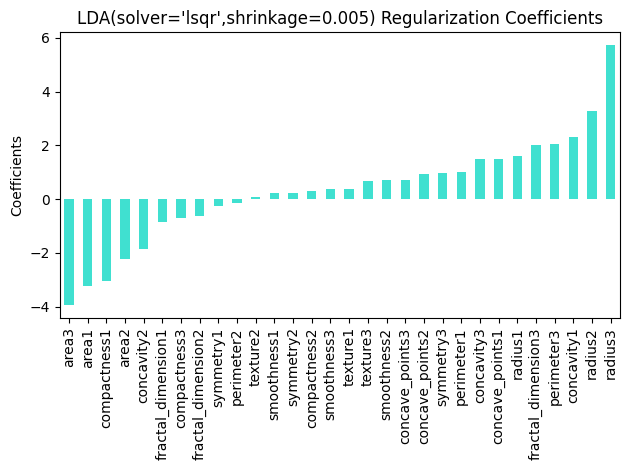


Accuracy score of LDA(solver="lsqr"): 	 0.9825
Number of features with coefs > 0.7: 	 19 



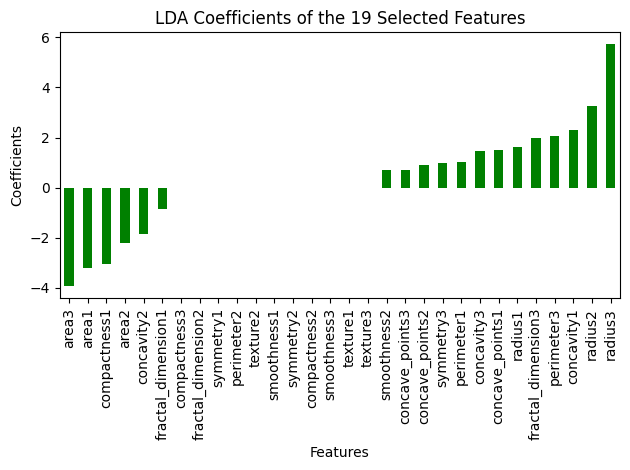


Example coefficients for radius1, radius2, radius3: 
radius1 coef: 	 1.619
radius2 coef: 	 3.28
radius3 coef: 	 5.72




<Figure size 640x480 with 0 Axes>

In [13]:
# Initialize LDA using 'lsqr' and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)

print('\n** NOTE: LDA does not drive coefficients to zero like Lasso (as seen above in block 4.1.1). **\n')
# Bar Plot of resulting COEF_s:
coefs = pd.Series(clf.coef_[0],X.columns).sort_values()
coefs.plot(kind='bar',color='turquoise')
plt.xticks(rotation=90)
plt.ylabel('Coefficients')
plt.title('LDA(solver=\'lsqr\',shrinkage=0.005) Regularization Coefficients')
plt.tight_layout()
plt.show()
plt.clf()

# Selecting features based on the absolute value of the coef_ compared to a threshold:
feature_names = list()
feature_values = list()
features_lda = 0
threshold = 0.7
for i in range(0,len(coefs)):
    if np.abs(coefs.iloc[i]) > threshold:
        feature_names.append(coefs.index[i])
        feature_values.append(coefs.iloc[i])
        features_lda += 1
    else:
        feature_names.append(coefs.index[i])
        feature_values.append(0)

print(f'\nAccuracy score of LDA(solver="lsqr"): \t {clf.score(X_test_scale,y_test):.4f}')
print('Number of features with coefs > 0.7: \t', features_lda,'\n')


# Plot of the 19 Features Selected by LDA:
plot_lda = pd.Series(feature_values,index=feature_names)
plot_lda.plot(kind='bar',color='green')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('LDA Coefficients of the 19 Selected Features')
plt.tight_layout()
plt.show()
plt.clf()

print('\nExample coefficients for radius1, radius2, radius3: ',)
print('radius1 coef: \t', coefs['radius1'].round(3))
print('radius2 coef: \t', coefs['radius2'].round(3))
print('radius3 coef: \t', coefs['radius3'].round(3))
print('\n')


## 4.2.2 Linear Discriminant Analysis – Feature Selection
*<div style="font-size:16px;color:lightpink"> *Note: Defining new LDA features training / testing sets as* **X_LDA_train** *and* **X_LDA_test** </div>*

In [14]:
# Initialize scaled training and testing data:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Initialize LDA and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)

# Define new training and testing sets as X_LDA_train, X_LDA_test
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_LDA_train = X_train_scale[X_train_scale.columns[np.abs(clf.coef_[0]) > 0.7]]
X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_LDA_test = X_test_scale[X_test_scale.columns[np.abs(clf.coef_[0]) > 0.7]]

## DON'T fall for this trap!
# X_LDA_test = X_test_scale[X_test_scale.columns[coefs.abs() > 0.7]]
## Using coefs.abs() with load the incorrect features due to the sort_values() called on coefs.
## Instead reference the original clf.coef_ as it has maintained its index order.

## Checking for expected features
# print(X_LDA_train.head())
print('\n')
print('X_LDA_train shape:\t',X_LDA_train.shape)
print('X_LDA_test shape:\t',X_LDA_test.shape)



X_LDA_train shape:	 (455, 19)
X_LDA_test shape:	 (114, 19)


## 4.2.3. Linear Discriminant Analysis – Validating Feature Selection with RFC
*Runtime approx. 13 Seconds with 50 loops:*

In [15]:
# Compare the performance of RandomForestClassifier on X_LDA_train and X_LDA_test VS full feature set.
print('\n')
# Loop to fit RFC with LDA features and the Full features set, 50 times:
# About 15 sec runtime with 50 loop runs.
rfc_list = list()
for i in range(1,51):
    # LDA FEATURE SET:
    clf_validate1 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate1.fit(X_LDA_train,y_train)
    LDA_score = clf_validate1.score(X_LDA_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    rfc_list.append([i+1,LDA_score,full_score])

c_names = ['random_state','LDA_score','full_score']
scores_df = pd.DataFrame(rfc_list,columns=c_names)
print(f'RFC LDA Avg Score: \t{scores_df["LDA_score"].mean():.4f}')
print(f'RFC Full Avg Score:\t{scores_df["full_score"].mean():.4f}')
print(f'RFC LDA Std Dev:   \t{scores_df["LDA_score"].std():.4f}')
print(f'RFC Full Std Dev:  \t{scores_df["full_score"].std():.4f}')

## The LDA feature set is underperforming compared to Lasso Features




RFC LDA Avg Score: 	0.9051
RFC Full Avg Score:	0.9225
RFC LDA Std Dev:   	0.0034
RFC Full Std Dev:  	0.0105


## 4.2.4. Linear Discriminant Analysis – Validating Feature Selection with SGDClassifier

In [16]:
# Compare the performance of SGDClassifier on X_LDA_train and X_LDA_test VS full feature set:
print('\n')
# Loop to fit SGDClassifier with LDA features and full features set, 50 times:
sgd_list = list()
for i in range(1,51):
    # Fit and score the LDA feature set:
    clf_validate1 = SGDClassifier(random_state=i+1,loss='hinge',penalty='l2',alpha=0.01)
    clf_validate1.fit(X_LDA_train,y_train)
    LDA_score = clf_validate1.score(X_LDA_test,y_test)
    # Fit and score the full feature set:
    clf_validate2 = SGDClassifier(random_state=i+1,loss='hinge',penalty='l2',alpha=0.01)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    sgd_list.append([i+1,LDA_score,full_score])


c_names = ['random_state','LDA_score','full_score']
scores_df = pd.DataFrame(sgd_list,columns=c_names)
print(f'SGDC LDA Avg Score: \t{scores_df["LDA_score"].mean():.4f}')
print(f'SGDC Full Avg Score:\t{scores_df["full_score"].mean():.4f}')
print(f'SGDC LDA Std Dev:   \t{scores_df["LDA_score"].std():.4f}')
print(f'SGDC Full Std Dev:  \t{scores_df["full_score"].std():.4f}')

# The LDA feature set is underperforming compared to Lasso Features



SGDC LDA Avg Score: 	0.9654
SGDC Full Avg Score:	0.9814
SGDC LDA Std Dev:   	0.0094
SGDC Full Std Dev:  	0.0060


## 4.9. Prepare Classifier Switching Class:
*A helper class to allow for trialing multiple classifier models in one pipeline.*

In [17]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier

class ClfSwitch(BaseEstimator):
    def __init__(self, estimator=SGDClassifier()):
        self.estimator = estimator
    def fit(self,xx,yy=None,**kwargs):
        self.estimator.fit(xx,yy)
        return self
    def predict(self,xx,yy=None):
        return self.estimator.predict(xx)
    def predict_proba(self,xx,yy=None):
        return self.estimator.predict_proba(xx)
    def score(self,xx,yy):
        return self.estimator.score(xx,yy)

## 5. Define Pipeline / Preprocessor / Search_space

In [18]:
scaler = StandardScaler()

# Scale incoming data.
# No need to impute because data was verified as complete.
preprocessor = ColumnTransformer([
    ('scaler', scaler, X_train.columns)
])

# Define a pipeline for GridSearchCV and RandomizedSearchCV,
# using the preprocessor and ClfSwitch class defined above:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', ClfSwitch())
])

# Define search_space for use in GridSearchCV and RandomizedSearchCV.
# Lists all the possible parameter values to select/optimize:
search_space = [
    {'clf__estimator': [RandomForestClassifier(random_state=13)],
     'clf__estimator__max_depth':[10,15,25],
     'clf__estimator__n_estimators':[150,200,250],
     },
    {'clf__estimator': [GradientBoostingClassifier(random_state=13)],
     'clf__estimator__learning_rate':[0.001,0.01,0.1],
     'clf__estimator__n_estimators':[150,200,250],
     },
    {'clf__estimator': [SGDClassifier(random_state=13)],
     'clf__estimator__loss': ['hinge','log_loss'],
     'clf__estimator__alpha': [0.001,0.005,0.01],
     'clf__estimator__penalty': ['l2']
     }
]

## 6. GridSearchCV Implementation &#8594; Analyze Results and Prepare to Tune Hyperparameters
*About 30 sec runtime with current search_space (9,9,6)*

In [19]:
# USE sklearn version 1.5.2 to suppress FutureWarning during fit:
gs = GridSearchCV(estimator=pipeline, param_grid=search_space, cv=5, error_score='raise')
gs.fit(X_train, y_train)

# Load the best estimator:
gs_best = gs.best_estimator_

# Load the best classifier:
gs_best_clf = gs_best.named_steps['clf']

print('\n')
# Print the best classifier's estimator:
print(gs_best_clf.get_params()['estimator'])

## Parameters can be accessed using:
#print(gs_best_clf.get_params()['estimator__max_depth'])
#print(gs_best_clf.get_params()['estimator__n_estimators'])

# Compare the accuracy score on test data to the best_score_ (training data):
print(f'GSCV .score() (Test Data):\t\t{gs_best.score(X_test, y_test):.4f}')
print(f'GSCV .best_score_ (Training Data):\t{gs.best_score_:.4f}')



SGDClassifier(alpha=0.01, random_state=13)
GSCV .score() (Test Data):		0.9649
GSCV .best_score_ (Training Data):	0.9736


## 6.1. Feature Analysis using cv_results_

In [20]:
# Used .cv_results_ to create a dataframe of the results:
cv_df = pd.DataFrame(gs.cv_results_)

columns_interest = [
    'param_clf__estimator',
    'param_clf__estimator__max_depth',
    'param_clf__estimator__n_estimators',
    'param_clf__estimator__loss',
    'param_clf__estimator__penalty',
    'param_clf__estimator__alpha',
    'mean_test_score',
    'std_test_score',
    'rank_test_score']

cv_df_results = cv_df[columns_interest].round(3)
print('\n')
cv_df_results

,param_clf__estimator,param_clf__estimator__max_depth,param_clf__estimator__n_estimators,param_clf__estimator__loss,param_clf__estimator__penalty,param_clf__estimator__alpha,mean_test_score,std_test_score,rank_test_score
0,RandomForestClassifier(random_state=13),10.0,150.0,NaN,NaN,NaN,0.954,0.018,15
1,RandomForestClassifier(random_state=13),10.0,200.0,NaN,NaN,NaN,0.956,0.018,11
2,RandomForestClassifier(random_state=13),10.0,250.0,NaN,NaN,NaN,0.958,0.015,7
3,RandomForestClassifier(random_state=13),15.0,150.0,NaN,NaN,NaN,0.954,0.018,15
4,RandomForestClassifier(random_state=13),15.0,200.0,NaN,NaN,NaN,0.956,0.018,11
5,RandomForestClassifier(random_state=13),15.0,250.0,NaN,NaN,NaN,0.958,0.015,7
6,RandomForestClassifier(random_state=13),25.0,150.0,NaN,NaN,NaN,0.954,0.018,15
7,RandomForestClassifier(random_state=13),25.0,200.0,NaN,NaN,NaN,0.956,0.018,11
8,RandomForestClassifier(random_state=13),25.0,250.0,NaN,NaN,NaN,0.958,0.015,7
9,GradientBoostingClassifier(random_state=13),NaN,150.0,NaN,NaN,NaN,0.613,0.036,24


## 7. Hyperparameter Tuning and Retesting models

In [21]:
# BLOCK 7 In progress ...

## 7.1. Diving Deeper into RandomForestClassifier Validation
*Using RandomForestClassifier(max_depth=10, n_estimators=150)*

In [22]:
# Modifying best rfc() to validate scores across dataset.
score_list = list()

scaler = StandardScaler()
scaler.fit(X)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Loop to analyze for any meaningful impact of Random_state on bootstrapping in the RFC().
for i in range(1,10):
    clf = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf.fit(X_train_scale,y_train)
    current_score = clf.score(X_test_scale,y_test)
    score_list.append([i+1,current_score])

c_names = ['random_state:','RFC score:']
score_df = pd.DataFrame(score_list,columns=c_names)
print(f'\nRFC Score Average:\t\t{score_df["RFC score:"].mean():.4f}')
print(f'RFC Score Std Deviation:\t{score_df["RFC score:"].std():.4f}')
# No indication that Random_state had a meaningful impact on our accuracy scores.

from time import perf_counter as tpc

start = tpc()
clf = RandomForestClassifier(random_state=11,max_depth=10,n_estimators=150)
clf.fit(X_train_scale,y_train)
current_score = clf.score(X_test_scale,y_test)
end = tpc()
print(f'\nRFC fit & score time: \t\t{((end - start) * 1000):.4f} ms')
print('\n')

score_df


RFC Score Average:		0.9250
RFC Score Std Deviation:	0.0146

RFC fit & score time: 		130.5567 ms




,random_state:,RFC score:
0,2,0.912281
1,3,0.912281
2,4,0.912281
3,5,0.921053
4,6,0.929825
5,7,0.929825
6,8,0.912281
7,9,0.947368
8,10,0.947368


## 7.2. Diving Deeper into SGDClassifier Validation:
*hinge vs log_loss, alpha = 0.01, penalty = l2*

*NOTE: Must scale data in this block because we are no longer using Pipeline and thus no preprocessor/scaler*


In [23]:
# Modifying best SGDClassifier() to validate scores across dataset and compare loss='hinge' vs. loss='log_loss'
score_list = list()

# Cannot stress enough the importance of calling the scaler before fitting to SGDClassifer!
scaler = StandardScaler()
scaler.fit(X)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Loop to analyze for any meaningful impact of Random_state on SGDClassifier().
for i in range(1,10):
    clf = SGDClassifier(random_state=i+1,loss='hinge',alpha=0.01,penalty='l2')
    clf.fit(X_train_scale,y_train)
    current_score = clf.score(X_test_scale,y_test)
    clf_log = SGDClassifier(random_state=i+1, loss='log_loss',alpha=0.01,penalty='l2')
    clf_log.fit(X_train_scale,y_train)
    current_score_log = clf.score(X_test_scale,y_test)
    score_list.append([i+1,current_score,current_score_log])

c_names = ['random_state:','SGDClassifier hinge score:','SGDClassifier log_loss score:']
score_df = pd.DataFrame(score_list,columns=c_names)
print(f'\nSGDC Hinge Score Average: \t\t{(score_df["SGDClassifier hinge score:"].mean()):.5f}')
print(f'SGDC Log_loss Score Average:\t\t{(score_df["SGDClassifier log_loss score:"].mean()):.5f}')
print(f'SGDC Hinge Score Std Deviation: \t{(score_df["SGDClassifier hinge score:"].std()):.5f}')
print(f'SGDC Log_loss Score Std Deviation:\t{(score_df["SGDClassifier log_loss score:"].std()):.5f}')
# No difference!

from time import perf_counter as tpc

start = tpc()
clf = SGDClassifier(random_state=11,loss='hinge',alpha=0.01,penalty='l2')
clf.fit(X_train_scale,y_train)
current_score = clf.score(X_test_scale,y_test)
end = tpc()
print(f'\nSGDC "Hinge" fit & score time:\t\t{((end - start) * 1000):.4f} ms')


start = tpc()
clf_log = SGDClassifier(random_state=11, loss='log_loss',alpha=0.01,penalty='l2')
clf_log.fit(X_train_scale,y_train)
current_score_log = clf.score(X_test_scale,y_test)
end = tpc()
print(f'SGDC "Log_loss" fit & score time:\t{((end - start) * 1000):.4f} ms')
print('\n')

score_df


SGDC Hinge Score Average: 		0.98148
SGDC Log_loss Score Average:		0.98148
SGDC Hinge Score Std Deviation: 	0.00686
SGDC Log_loss Score Std Deviation:	0.00686

SGDC "Hinge" fit & score time:		1.0694 ms
SGDC "Log_loss" fit & score time:	1.1884 ms




,random_state:,SGDClassifier hinge score:,SGDClassifier log_loss score:
0,2,0.982456,0.982456
1,3,0.982456,0.982456
2,4,0.991228,0.991228
3,5,0.982456,0.982456
4,6,0.982456,0.982456
5,7,0.982456,0.982456
6,8,0.982456,0.982456
7,9,0.982456,0.982456
8,10,0.964912,0.964912


## 7.3. RandomizedSearchCV Implementation
*Note: Runtime benefits from defining n_iter parameter (default n_iter=10)*

*When n_iter=5 the Runtime is 5 to 8 seconds, when n_iter=10 the Runtime is 8 to 18 seconds*

In [24]:
# RandomizedSearchCV method:
from sklearn.model_selection import RandomizedSearchCV
print('\n')
rs = RandomizedSearchCV(estimator=pipeline, param_distributions=search_space, cv=5, n_iter=10, error_score='raise')
rs.fit(X_train, y_train)

# Load the best estimator:
rs_best = rs.best_estimator_
# Load the best classifier:
rs_best_clf = rs_best.named_steps['clf']
# Print the best classifier's estimator:
print(rs_best_clf.get_params()['estimator'])

# Compare the test data score to the training data (best_score_):
print(f'RandomizedSearchCV Best test score: \t{rs_best.score(X_test, y_test):.4f}')
print(f'RandomizedSearchCV Best training score:\t{rs.best_score_:.4f}')



RandomForestClassifier(max_depth=25, n_estimators=250, random_state=13)
RandomizedSearchCV Best test score: 	0.9211
RandomizedSearchCV Best training score:	0.9582
